In [1]:
#relevant imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, KFold
from skimage import io
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import torch.utils.data as data
import torchvision.utils as vutils
from torchinfo import summary
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fold_info = pd.read_csv("/kaggle/input/breakhis/Folds.csv") 
class_names = ['malignant', 'benign']
fold_info = fold_info.rename(columns={'filename': 'path'})
fold_info['label'] = fold_info.path.apply(lambda x: x.split('/')[3])
fold_info['label_int'] = fold_info.label.apply(lambda x: class_names.index(x))

In [3]:
fold_info

,fold,mag,grp,path,label,label_int
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
...,...,...,...,...,...,...
39540,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
39541,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
39542,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
39543,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0


Thus we can see that data is presented as 5 folds for k-fold cross validation, train and test. 

In [4]:
train_df=fold_info[fold_info.grp=='train']
test_df=fold_info[fold_info.grp=='test']
test_df['path'] = ('/kaggle/input/breakhis/BreaKHis_v1/' + test_df['path'])

/tmp/ipykernel_31/2481831445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['path'] = ('/kaggle/input/breakhis/BreaKHis_v1/' + test_df['path'])


In [5]:
train_df

,fold,mag,grp,path,label,label_int
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
...,...,...,...,...,...,...
36457,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
36458,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
36459,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
36460,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0


In [6]:
test_df

,fold,mag,grp,path,label,label_int
5005,1,100,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,1
5006,1,100,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,1
5007,1,100,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,1
5008,1,100,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,1
5009,1,100,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,1
...,...,...,...,...,...,...
39540,5,400,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,malignant,0
39541,5,400,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,malignant,0
39542,5,400,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,malignant,0
39543,5,400,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,malignant,0


thus a separate test dataset has been created which will not be involved in the kfold cross validation procedure.

In [7]:
fold_data = [group for _, group in train_df.groupby('fold')]
fold_data[4]


,fold,mag,grp,path,label,label_int
31636,5,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
31637,5,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
31638,5,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
31639,5,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
31640,5,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1
...,...,...,...,...,...,...
36457,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
36458,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
36459,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0
36460,5,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0


add stuff about sizes of diff folds, visualisations etc.

In [8]:
for i,_ in enumerate(fold_data):
    selected_fold=i+1
    fold_data[i]=fold_info.query("fold == @selected_fold").copy()
    fold_data[i]['path'] = ('/kaggle/input/breakhis/BreaKHis_v1/' + fold_data[i]['path'])


In [9]:
class CustomDataset(data.Dataset):
    '''
    Implementation of a custom dataset class.
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['path']
        label = self.df.iloc[index]['label_int']
        img = Image.open(filename).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.df)

In [10]:
MEAN, STD=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
IMAGE_SIZE=224
BATCH_SIZE=64

In [11]:
data_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.Normalize(MEAN, STD)
])

In [12]:
fold_datasets = []
for fold in fold_data:
#     fold=fold.sample(frac=1).reset_index(drop=True)
    dataset = CustomDataset(pd.concat([fold.iloc[:200], fold.iloc[-200:]]), transform=data_transforms)
    fold_datasets.append(dataset)
#     dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
#     dataloaders.append(dataloader)

test_df = test_df.sample(frac=1).reset_index(drop=True)
test_set=CustomDataset(test_df[:400], transform=data_transforms)
test_loader=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
def plot_images(dataloader, num_images=16):
    """
    function for easy visualisation of images from dataset.
    args:
        dataloader: a pytorch dataloader object
        num_images: number of images to be plotted
    """
    
    # Get a batch of images from the dataloader
    data = next(iter(dataloader))
    images, _ = data

    # Generate a grid of images
    img_grid = vutils.make_grid(images[:num_images], nrow=4, padding=2, normalize=True)

    # Convert the image grid to a numpy array and transpose the dimensions
    img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

    # Plot the image grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(img_grid)
    plt.title("Sample Images")
    plt.show()


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


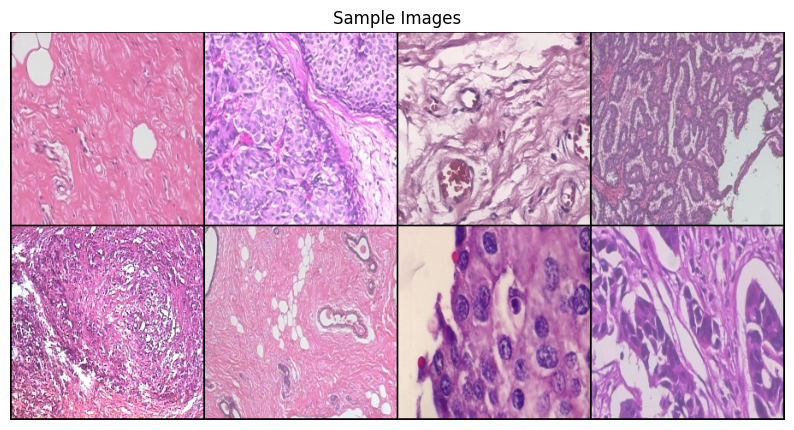

In [14]:
plot_images(test_loader, num_images=8)

In [15]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, num):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/accuracy_h{num}.png')
    
    # loss plots
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/loss_h{num}.png")

In [16]:
class ResNet18(nn.Module):
    '''
    Class to define a pretrained ResNet18 model. 
    '''
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=True)

    def forward(self, x):
        return self.resnet18(x)


In [17]:
class ShuffleNet(nn.Module):
    """
    Class to define a pretrained shufflenet model.
    """
    def __init__(self):
        super().__init__()
        self.shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
        
    def forward(self, x):
        return self.shufflenet(x)


In [18]:
class VGG16(nn.Module):
    """
    Class to define a pretrained VGG16 model
    """
    def __init__(self):
        super().__init__()
        self.vgg16 = models.vgg16(pretrained=True)

    def forward(self, x):
        return self.vgg16(x)


In [19]:
class MobileNetV2(nn.Module):
    """
    Class to define a pretrained MobileNetV2 model
    """
    def __init__(self):
        super().__init__()
        self.mobilenetv2 = models.mobilenet_v2(pretrained=True)

    def forward(self, x):
        return self.mobilenetv2(x)



In [20]:
class AlexNet(nn.Module):
    """
    Class to define a pretrained AlexNet model
    """
    def __init__(self):
        super().__init__()
        self.alexnet = models.alexnet(pretrained=True)

    def forward(self, x):
        return self.alexnet(x)


In [21]:
B=0.05 #threshold value to determine the activation of second model

def weight_factor(class_prob):
    """
    function to calculate weight factor as defined in the paper.
    args:
        class_prob: pytorch tensor with dims [batch_size, 2]
    """
    p1 = class_prob[:, 0]
    p2 = class_prob[:, 1]
    w = torch.abs(torch.mul(p1, torch.log2(2 * p2)) + torch.mul(p2, torch.log2(2 * p1)))
    return w

In [22]:
def reset_weights(m):
    """
    reset model weights
    """
    print(" --- resetting model weights to prevent weight leakage --- ")
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


  


In [23]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device
              ):
    """
    One epoch of training.
    Args:
        model: the pytorch model to be trained
        dataloader: pytorch DataLoader object to train the model on
        loss_fn: pytorch loss function
        optimizer: pytorch optimizer function to minimise loss
        device: gpu/cpu
    
    Returns:
        train_loss
        train_acc
    """
    
    model.train()
    train_loss, train_acc=0,0
    
    for batch, (X,y) in enumerate(dataloader):
        
        X,y = X.to(device), y.to(device)
        
        y_pred=model(X)
        
        loss=loss_fn(y_pred, y)
        train_loss +=loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
    

In [24]:
def valid_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: torch.device) :
    """
    One epoch of validation.
    Args:
        model: the pytorch model to be tested
        dataloader: pytorch DataLoader object to test the model on
        optimizer: pytorch optimizer to minimize loss
        loss_fn: pytorch loss function
        device: gpu/cpu
    
    Return:
        valid_loss
        valid_acc
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    valid_loss, valid_acc = 0, 0



    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            valid_pred_logits = model(X)


            # 2. Calculate and accumulate loss
            loss = loss_fn(valid_pred_logits, y)
            valid_loss += loss.item()


            # Calculate and accumulate accuracy
            valid_pred_labels = valid_pred_logits.argmax(dim=1)
            valid_acc += ((valid_pred_labels == y).sum().item()/len(valid_pred_labels))


    #get avg metrics
    valid_loss = valid_loss / len(dataloader)
    valid_acc = valid_acc / len(dataloader)



    return valid_loss, valid_acc


In [25]:
def kfold_step(model: torch.nn.Module,
              train_dataloader: torch.utils.data.DataLoader,
              valid_dataloader: torch.utils.data.DataLoader,
              optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module,
              epochs:int,
              device: torch.device):
    """
    One fold of k-fold cross validation, consists of repeated training and validation over epochs.
    Args:
        model: the pytorch model to be tested
        train_dataloader: pytorch DataLoader object to train the model on
        valid_dataloader: pytorch DataLoader object to validate the model on
        optimizer: pytorch optimizer to minimize loss
        loss_fn: pytorch loss function
        device: gpu/cpu
        epochs: number of epochs
        
    Return:
        fold_results: dict
        model.state_dict()
    
    
    """
    
    model.to(device)
    fold_results = {"train_loss": [],
                   "train_acc": [],
                   "valid_loss": [],
                   "valid_acc": []
                      }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader = train_dataloader,
                                          loss_fn = loss_fn ,
                                          optimizer = optimizer,
                                          device = device)
        valid_loss, valid_acc = valid_step(model = model,
                                          dataloader = valid_dataloader,
                                          optimizer = optimizer,
                                          loss_fn = loss_fn,
                                          device = device )
        
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc %: {train_acc*100:.2f} | "
          f"valid_loss: {valid_loss:.4f} | "
          f"valid_acc %: {valid_acc*100:.2f}  "
        )
        
        fold_results["train_loss"].append(train_loss)
        fold_results["train_acc"].append(train_acc)
        fold_results["valid_loss"].append(valid_loss)
        fold_results["valid_acc"].append(valid_acc)

    return fold_results, model.state_dict()

In [26]:
#KFOLD CROSS VALIDATION
def kfold_cross_val(model : torch.nn.Module,
                    fold_datasets: list,
                    optimizer : torch.optim.Optimizer,
                    loss_fn: torch.nn.Module,
                    epochs:int,
                    device: torch.device,
                    model_name : str
                   ):
    """
    Complete K-Fold cross validation over all folds and saving the best model.
    Args:
        model: the pytorch model to be tested
        fold_datasets: list of dataframes grouped by fold number
        optimizer: pytorch optimizer to minimize loss
        loss_fn: pytorch loss function
        device: gpu/cpu
        epochs: number of epochs
        model_name: name of model (needed for save path)
    
    """
    all_fold_results=[]

    for i, val_set in enumerate(fold_datasets):
        print(f"-------- Fold {i+1} results --------")
        best_val_acc = 0
        train_sets = [d for j, d in enumerate(fold_datasets) if j != i]
        fold_train_set = ConcatDataset(train_sets)
        train_loader = DataLoader(fold_train_set, batch_size = BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle=True)
        
        

        fold_results, model_state = kfold_step(model = model,
                               train_dataloader = train_loader,
                               valid_dataloader = val_loader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = epochs,
                               device = device)

        all_fold_results.append(fold_results)

        if fold_results["valid_acc"][-1] > best_val_acc:
            PATH = Path('/kaggle/working/', model_name+'.pth')
            torch.save(model_state, PATH)
            
#         model.apply(reset_weights)
        
    return all_fold_results, PATH


In [27]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) :
    """
    One epoch of testing.
    Args:
        model: the pytorch model to be tested
        dataloader: pytorch DataLoader object to test the model on
        loss_fn: pytorch loss function
        device: gpu/cpu
    """
    # Put model in eval mode
    model.to(device)
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc, recall, precision, specificity, f1, auc = 0, 0, 0, 0, 0, 0 ,0

    #Create lists to store indices for subset creation
    selected_batch_indices = []
    selected_sample_indices = []
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)
            
            #get class probabilities and subsequently weight factor
            class_prob=F.softmax(test_pred_logits, dim=1)
            weights=weight_factor(class_prob)
            
            #sending logits to cpu for metrics calculation
            y_cpu=y.detach().cpu().numpy()
            y_pred_cpu=test_pred_logits.detach().cpu().numpy()
            y_pred_bin = np.argmax(y_pred_cpu, axis=1)
            

            #store indices of images with weight factor less than threshold to access labels
            selected_sample_indices_batch = [i for i, w in enumerate(weights) if w < B]
            selected_batch_indices += [batch] * len(selected_sample_indices_batch)
            selected_sample_indices += selected_sample_indices_batch

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
    

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
            #calculation of metrics
            precision+=precision_score(y_cpu, y_pred_bin)
            recall+=recall_score(y_cpu, y_pred_bin)
            f1+=f1_score(y_cpu, y_pred_bin)
            auc+=roc_auc_score(y_cpu, y_pred_bin)
            specificity+=recall_score(y_cpu, y_pred_bin, pos_label=0)
            



    
    #create a subset of the relevant images and add their labels
    selected_indices = [i * BATCH_SIZE + j for i, j in zip(selected_batch_indices, selected_sample_indices)]
    final_subset = Subset(test_set, selected_indices)
    
    #get avg metrics
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    precision=precision/len(test_loader)*100 #percentage
    recall=recall/len(test_loader)*100 #percentage
    auc=auc/len(test_loader)
    f1=f1/len(test_loader)
    specificity=specificity/len(test_loader)*100 #percentage

    
    return test_loss, test_acc, final_subset, weights, precision, recall, auc, f1, specificity
    

In [28]:

def train(model: torch.nn.Module, 
          train_datasets: list,  
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          model_name: str
         ) :
    """
    Joint train and test step. Training done using k-fold cross validation
    Args:
        model: the pytorch model to be trained
        train_datasets: list of dataframes corresponding to fold number
        test_dataloader: pytorch DataLoader object to test the model on
        loss_fn: pytorch loss function
        optimizer: pytorch optimizer function to minimise loss
        epochs: number of epochs 
        device: gpu/cpu
        model_name: name of the model, needed for save path
  
    """
     
    final_subset=[]
    
    results = { "test_loss": [],
              "test_acc": [],
              "precision": [],
              "recall": [],
              "auc": [],
              "specificity": [],
              "f1": []}
    
    # Make sure model on target device
    model.to(device)
    
    all_fold_results, PATH = kfold_cross_val(model = model,
                                      fold_datasets = train_datasets,
                                      optimizer = optimizer,
                                      loss_fn = loss_fn ,
                                      epochs = epochs , 
                                      device = device ,
                                      model_name = model_name )
    saved_model=model.__class__()
    saved_model.load_state_dict(torch.load(PATH))
    
    
    
    test_loss, test_acc , final_subset, weights,precision, recall, auc, f1, specificity = test_step(model=saved_model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
    
    print(f"test_loss: {test_loss:.4f} | "
          f"test_acc %: {test_acc*100:.2f} | "
            f"precision %: {precision:.2f} | "
            f"recall %: {recall: .2f} | "
            f"auc : {auc :.4f} | "
            f"specificity %: {specificity:.2f} | "
            f"f1: {f1:.4f} ")
    

    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["auc"].append(auc)
    results["specificity"].append(specificity)
    results["f1"].append(f1)

    
    return results, final_subset, weights

In [29]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Hybrid 1: MobileNetV2 + ResNet18

In [30]:
mobilenet_h1 = MobileNetV2()

mobilenet_h1_opt=torch.optim.Adam(params=mobilenet_h1.parameters(),
                                 lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 64.8MB/s]


In [31]:
resnet_h1 = ResNet18()

resnet_h1_opt=torch.optim.Adam(params=resnet_h1.parameters(),
                              lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 272MB/s]


In [32]:
results, final_subset, weights = train( model = mobilenet_h1,
                              train_datasets = fold_datasets,
                              test_dataloader = test_loader,
                              optimizer = mobilenet_h1_opt,
                              loss_fn=F.cross_entropy,
                              epochs = 12,
                              device = device, 
                              model_name = 'mobilenet_h1'
                             )


-------- Fold 1 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.9136 | train_acc %: 52.56 | valid_loss: 0.6698 | valid_acc %: 95.09  
Epoch: 2 | train_loss: 0.0960 | train_acc %: 99.12 | valid_loss: 0.0140 | valid_acc %: 99.78  
Epoch: 3 | train_loss: 0.0140 | train_acc %: 99.81 | valid_loss: 0.0010 | valid_acc %: 100.00  
Epoch: 4 | train_loss: 0.0065 | train_acc %: 99.88 | valid_loss: 0.0009 | valid_acc %: 100.00  
Epoch: 5 | train_loss: 0.0117 | train_acc %: 99.75 | valid_loss: 0.0007 | valid_acc %: 100.00  
Epoch: 6 | train_loss: 0.0019 | train_acc %: 100.00 | valid_loss: 0.0008 | valid_acc %: 100.00  
Epoch: 7 | train_loss: 0.0129 | train_acc %: 99.69 | valid_loss: 0.0004 | valid_acc %: 100.00  
Epoch: 8 | train_loss: 0.0016 | train_acc %: 100.00 | valid_loss: 0.0003 | valid_acc %: 100.00  
Epoch: 9 | train_loss: 0.0014 | train_acc %: 100.00 | valid_loss: 0.0003 | valid_acc %: 100.00  
Epoch: 10 | train_loss: 0.0015 | train_acc %: 100.00 | valid_loss: 0.0003 | valid_acc %: 100.00  
Epoch: 11 | train_loss: 0.0010 | trai

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.5403 | train_acc %: 55.12 | valid_loss: 3.7345 | valid_acc %: 50.00  
Epoch: 2 | train_loss: 0.9756 | train_acc %: 79.31 | valid_loss: 2.3885 | valid_acc %: 53.79  
Epoch: 3 | train_loss: 0.2519 | train_acc %: 92.75 | valid_loss: 0.2166 | valid_acc %: 91.29  
Epoch: 4 | train_loss: 0.1153 | train_acc %: 97.19 | valid_loss: 0.0567 | valid_acc %: 99.11  
Epoch: 5 | train_loss: 0.0596 | train_acc %: 99.00 | valid_loss: 0.0246 | valid_acc %: 99.78  
Epoch: 6 | train_loss: 0.0473 | train_acc %: 99.12 | valid_loss: 0.0172 | valid_acc %: 99.78  
Epoch: 7 | train_loss: 0.0309 | train_acc %: 99.50 | valid_loss: 0.0153 | valid_acc %: 100.00  
Epoch: 8 | train_loss: 0.0279 | train_acc %: 99.44 | valid_loss: 0.0130 | valid_acc %: 100.00  
Epoch: 9 | train_loss: 0.0340 | train_acc %: 98.88 | valid_loss: 0.0092 | valid_acc %: 99.78  
Epoch: 10 | train_loss: 0.0254 | train_acc %: 99.38 | valid_loss: 0.0085 | valid_acc %: 100.00  
Epoch: 11 | train_loss: 0.0165 | train_acc %: 

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.3336 | train_acc %: 55.06 | valid_loss: 3.9419 | valid_acc %: 46.65  
Epoch: 2 | train_loss: 0.6322 | train_acc %: 86.00 | valid_loss: 2.7120 | valid_acc %: 55.13  
Epoch: 3 | train_loss: 0.1525 | train_acc %: 95.50 | valid_loss: 0.4656 | valid_acc %: 87.50  
Epoch: 4 | train_loss: 0.0824 | train_acc %: 97.69 | valid_loss: 0.5988 | valid_acc %: 82.37  
Epoch: 5 | train_loss: 0.0454 | train_acc %: 99.12 | valid_loss: 0.5570 | valid_acc %: 86.38  
Epoch: 6 | train_loss: 0.0261 | train_acc %: 99.56 | valid_loss: 0.6182 | valid_acc %: 85.27  
Epoch: 7 | train_loss: 0.0185 | train_acc %: 99.81 | valid_loss: 0.6139 | valid_acc %: 85.49  
Epoch: 8 | train_loss: 0.0226 | train_acc %: 99.56 | valid_loss: 0.9340 | valid_acc %: 79.91  
Epoch: 9 | train_loss: 0.0168 | train_acc %: 99.81 | valid_loss: 0.3332 | valid_acc %: 90.85  
Epoch: 10 | train_loss: 0.0162 | train_acc %: 99.81 | valid_loss: 0.5415 | valid_acc %: 85.94  
Epoch: 11 | train_loss: 0.0196 | train_acc %: 99.

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.1997 | train_acc %: 60.56 | valid_loss: 4.7914 | valid_acc %: 52.01  
Epoch: 2 | train_loss: 0.5969 | train_acc %: 87.94 | valid_loss: 1.8062 | valid_acc %: 62.05  
Epoch: 3 | train_loss: 0.1677 | train_acc %: 95.62 | valid_loss: 0.2323 | valid_acc %: 94.64  
Epoch: 4 | train_loss: 0.0934 | train_acc %: 97.62 | valid_loss: 0.0321 | valid_acc %: 99.78  
Epoch: 5 | train_loss: 0.0490 | train_acc %: 98.94 | valid_loss: 0.0121 | valid_acc %: 100.00  
Epoch: 6 | train_loss: 0.0407 | train_acc %: 99.12 | valid_loss: 0.0181 | valid_acc %: 100.00  
Epoch: 7 | train_loss: 0.0378 | train_acc %: 99.06 | valid_loss: 0.0091 | valid_acc %: 100.00  
Epoch: 8 | train_loss: 0.0264 | train_acc %: 99.25 | valid_loss: 0.0053 | valid_acc %: 100.00  
Epoch: 9 | train_loss: 0.0156 | train_acc %: 99.56 | valid_loss: 0.0049 | valid_acc %: 100.00  
Epoch: 10 | train_loss: 0.0168 | train_acc %: 99.69 | valid_loss: 0.0038 | valid_acc %: 100.00  
Epoch: 11 | train_loss: 0.0083 | train_acc 

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.3384 | train_acc %: 57.19 | valid_loss: 5.4345 | valid_acc %: 50.67  
Epoch: 2 | train_loss: 0.6014 | train_acc %: 87.88 | valid_loss: 2.6692 | valid_acc %: 53.79  
Epoch: 3 | train_loss: 0.1497 | train_acc %: 95.50 | valid_loss: 0.2258 | valid_acc %: 92.41  
Epoch: 4 | train_loss: 0.1012 | train_acc %: 97.00 | valid_loss: 0.0554 | valid_acc %: 98.44  
Epoch: 5 | train_loss: 0.0500 | train_acc %: 98.56 | valid_loss: 0.0165 | valid_acc %: 99.78  
Epoch: 6 | train_loss: 0.0444 | train_acc %: 98.81 | valid_loss: 0.0137 | valid_acc %: 100.00  
Epoch: 7 | train_loss: 0.0415 | train_acc %: 98.94 | valid_loss: 0.0074 | valid_acc %: 100.00  
Epoch: 8 | train_loss: 0.0368 | train_acc %: 98.88 | valid_loss: 0.0036 | valid_acc %: 100.00  
Epoch: 9 | train_loss: 0.0318 | train_acc %: 99.19 | valid_loss: 0.1090 | valid_acc %: 96.21  
Epoch: 10 | train_loss: 0.0311 | train_acc %: 99.25 | valid_loss: 0.0073 | valid_acc %: 100.00  
Epoch: 11 | train_loss: 0.0125 | train_acc %:

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

test_loss: 0.7641 | test_acc %: 85.27 | precision %: 70.12 | recall %:  79.03 | auc : 0.8343 | specificity %: 87.84 | f1: 0.7367 


In [33]:
len(final_subset)

2

In [34]:
hybrid_loader1 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
results, final_subset, weights=train(model=resnet_h1,
              train_datasets = fold_datasets,
              test_dataloader=hybrid_loader1,
              optimizer=resnet_h1_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, model_name='resnet_h1')

-------- Fold 1 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1 | train_loss: 3.3580 | train_acc %: 57.31 | valid_loss: 0.4907 | valid_acc %: 95.98  
Epoch: 2 | train_loss: 0.0590 | train_acc %: 99.50 | valid_loss: 0.0215 | valid_acc %: 99.78  
Epoch: 3 | train_loss: 0.0103 | train_acc %: 99.88 | valid_loss: 0.0043 | valid_acc %: 100.00  
Epoch: 4 | train_loss: 0.0036 | train_acc %: 100.00 | valid_loss: 0.0026 | valid_acc %: 100.00  
Epoch: 5 | train_loss: 0.0031 | train_acc %: 100.00 | valid_loss: 0.0019 | valid_acc %: 100.00  
Epoch: 6 | train_loss: 0.0022 | train_acc %: 100.00 | valid_loss: 0.0017 | valid_acc %: 100.00  
Epoch: 7 | train_loss: 0.0021 | train_acc %: 100.00 | valid_loss: 0.0015 | valid_acc %: 100.00  
Epoch: 8 | train_loss: 0.0017 | train_acc %: 100.00 | valid_loss: 0.0012 | valid_acc %: 100.00  
Epoch: 9 | train_loss: 0.0018 | train_acc %: 100.00 | valid_loss: 0.0013 | valid_acc %: 100.00  
Epoch: 10 | train_loss: 0.0022 | train_acc %: 99.94 | valid_loss: 0.0018 | valid_acc %: 100.00  
Epoch: 11 | train_loss: 0.0019 | tr

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0952 | train_acc %: 78.50 | valid_loss: 4.8982 | valid_acc %: 64.96  
Epoch: 2 | train_loss: 0.2233 | train_acc %: 94.44 | valid_loss: 0.8076 | valid_acc %: 68.30  
Epoch: 3 | train_loss: 0.1528 | train_acc %: 94.75 | valid_loss: 0.2009 | valid_acc %: 92.41  
Epoch: 4 | train_loss: 0.0999 | train_acc %: 96.00 | valid_loss: 0.1604 | valid_acc %: 92.19  
Epoch: 5 | train_loss: 0.0753 | train_acc %: 97.12 | valid_loss: 0.1190 | valid_acc %: 92.63  
Epoch: 6 | train_loss: 0.1142 | train_acc %: 96.06 | valid_loss: 0.1141 | valid_acc %: 97.99  
Epoch: 7 | train_loss: 0.1120 | train_acc %: 95.81 | valid_loss: 0.1063 | valid_acc %: 93.75  
Epoch: 8 | train_loss: 0.0824 | train_acc %: 97.06 | valid_loss: 0.2140 | valid_acc %: 88.84  
Epoch: 9 | train_loss: 0.0565 | train_acc %: 98.00 | valid_loss: 0.0729 | valid_acc %: 96.21  
Epoch: 10 | train_loss: 0.0486 | train_acc %: 97.88 | valid_loss: 0.4610 | valid_acc %: 90.85  
Epoch: 11 | train_loss: 0.0424 | train_acc %: 98.

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7118 | train_acc %: 81.94 | valid_loss: 8.0882 | valid_acc %: 59.15  
Epoch: 2 | train_loss: 0.2302 | train_acc %: 92.44 | valid_loss: 1.2735 | valid_acc %: 82.81  
Epoch: 3 | train_loss: 0.1315 | train_acc %: 95.19 | valid_loss: 0.9899 | valid_acc %: 84.82  
Epoch: 4 | train_loss: 0.1099 | train_acc %: 95.75 | valid_loss: 1.4778 | valid_acc %: 79.46  
Epoch: 5 | train_loss: 0.1126 | train_acc %: 95.81 | valid_loss: 0.5630 | valid_acc %: 91.29  
Epoch: 6 | train_loss: 0.0726 | train_acc %: 97.00 | valid_loss: 1.2328 | valid_acc %: 84.82  
Epoch: 7 | train_loss: 0.1014 | train_acc %: 95.88 | valid_loss: 0.8558 | valid_acc %: 90.18  
Epoch: 8 | train_loss: 0.0598 | train_acc %: 97.69 | valid_loss: 0.6648 | valid_acc %: 89.29  
Epoch: 9 | train_loss: 0.0639 | train_acc %: 97.69 | valid_loss: 0.9956 | valid_acc %: 85.04  
Epoch: 10 | train_loss: 0.0540 | train_acc %: 98.06 | valid_loss: 1.1265 | valid_acc %: 82.59  
Epoch: 11 | train_loss: 0.0257 | train_acc %: 99.

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3488 | train_acc %: 86.00 | valid_loss: 13.0527 | valid_acc %: 55.80  
Epoch: 2 | train_loss: 0.2311 | train_acc %: 94.50 | valid_loss: 0.4780 | valid_acc %: 87.50  
Epoch: 3 | train_loss: 0.1333 | train_acc %: 95.19 | valid_loss: 0.3450 | valid_acc %: 87.05  
Epoch: 4 | train_loss: 0.0956 | train_acc %: 96.81 | valid_loss: 0.1328 | valid_acc %: 94.42  
Epoch: 5 | train_loss: 0.0861 | train_acc %: 96.88 | valid_loss: 0.2270 | valid_acc %: 92.86  
Epoch: 6 | train_loss: 0.0976 | train_acc %: 95.81 | valid_loss: 1.5657 | valid_acc %: 76.34  
Epoch: 7 | train_loss: 0.0851 | train_acc %: 95.94 | valid_loss: 0.2553 | valid_acc %: 87.50  
Epoch: 8 | train_loss: 0.0646 | train_acc %: 97.38 | valid_loss: 0.0649 | valid_acc %: 98.21  
Epoch: 9 | train_loss: 0.0470 | train_acc %: 98.25 | valid_loss: 0.0451 | valid_acc %: 98.21  
Epoch: 10 | train_loss: 0.0840 | train_acc %: 97.31 | valid_loss: 0.1981 | valid_acc %: 93.08  
Epoch: 11 | train_loss: 0.0585 | train_acc %: 98

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6009 | train_acc %: 82.56 | valid_loss: 5.0793 | valid_acc %: 59.82  
Epoch: 2 | train_loss: 0.2114 | train_acc %: 95.19 | valid_loss: 0.6987 | valid_acc %: 88.62  
Epoch: 3 | train_loss: 0.1432 | train_acc %: 95.69 | valid_loss: 0.5379 | valid_acc %: 85.71  
Epoch: 4 | train_loss: 0.1243 | train_acc %: 96.19 | valid_loss: 0.4726 | valid_acc %: 81.70  
Epoch: 5 | train_loss: 0.0964 | train_acc %: 96.31 | valid_loss: 0.2211 | valid_acc %: 90.62  
Epoch: 6 | train_loss: 0.0816 | train_acc %: 96.94 | valid_loss: 0.2583 | valid_acc %: 89.96  
Epoch: 7 | train_loss: 0.0860 | train_acc %: 96.50 | valid_loss: 0.1682 | valid_acc %: 91.29  
Epoch: 8 | train_loss: 0.0789 | train_acc %: 97.50 | valid_loss: 0.0450 | valid_acc %: 98.66  
Epoch: 9 | train_loss: 0.0420 | train_acc %: 98.56 | valid_loss: 0.3662 | valid_acc %: 89.29  
Epoch: 10 | train_loss: 0.0508 | train_acc %: 98.38 | valid_loss: 0.0123 | valid_acc %: 99.78  
Epoch: 11 | train_loss: 0.0257 | train_acc %: 99.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: Undef

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# Hybrid 2 : VGG16 + ResNet18

In [36]:
vgg_h2=VGG16()

vgg_h2_opt =  torch.optim.Adam(params = vgg_h2.parameters(),
                               lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 269MB/s] 


In [37]:
resnet_h2 = ResNet18()

resnet_h2_opt=torch.optim.Adam(params=resnet_h2.parameters(),
                              lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
results, final_subset, weights = train( model = vgg_h2,
                              train_datasets = fold_datasets,
                              test_dataloader = test_loader,
                              optimizer = vgg_h2_opt,
                              loss_fn=F.cross_entropy,
                              epochs = 12,
                              device = device, 
                              model_name = 'vgg_h2'
                             )

-------- Fold 1 results --------


  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1 | train_loss: 1.0366 | train_acc %: 75.94 | valid_loss: 0.0761 | valid_acc %: 97.54  
Epoch: 2 | train_loss: 0.0774 | train_acc %: 97.31 | valid_loss: 0.0329 | valid_acc %: 99.33  
Epoch: 3 | train_loss: 0.0569 | train_acc %: 98.19 | valid_loss: 0.0193 | valid_acc %: 99.55  
Epoch: 4 | train_loss: 0.0086 | train_acc %: 99.75 | valid_loss: 0.0064 | valid_acc %: 99.78  
Epoch: 5 | train_loss: 0.0030 | train_acc %: 99.94 | valid_loss: 0.0009 | valid_acc %: 100.00  
Epoch: 6 | train_loss: 0.0003 | train_acc %: 100.00 | valid_loss: 0.0003 | valid_acc %: 100.00  
Epoch: 7 | train_loss: 0.0001 | train_acc %: 100.00 | valid_loss: 0.0001 | valid_acc %: 100.00  
Epoch: 8 | train_loss: 0.0001 | train_acc %: 100.00 | valid_loss: 0.0001 | valid_acc %: 100.00  
Epoch: 9 | train_loss: 0.0000 | train_acc %: 100.00 | valid_loss: 0.0000 | valid_acc %: 100.00  
Epoch: 10 | train_loss: 0.0000 | train_acc %: 100.00 | valid_loss: 0.0000 | valid_acc %: 100.00  
Epoch: 11 | train_loss: 0.0000 | train

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6359 | train_acc %: 47.12 | valid_loss: 0.7723 | valid_acc %: 49.33  
Epoch: 2 | train_loss: 0.7309 | train_acc %: 48.69 | valid_loss: 0.6972 | valid_acc %: 50.67  
Epoch: 3 | train_loss: 0.7035 | train_acc %: 50.81 | valid_loss: 0.6946 | valid_acc %: 48.66  
Epoch: 4 | train_loss: 0.7006 | train_acc %: 51.38 | valid_loss: 0.7017 | valid_acc %: 50.00  
Epoch: 5 | train_loss: 0.7096 | train_acc %: 49.12 | valid_loss: 0.6955 | valid_acc %: 50.00  
Epoch: 6 | train_loss: 0.7061 | train_acc %: 49.62 | valid_loss: 0.6949 | valid_acc %: 47.99  
Epoch: 7 | train_loss: 0.7036 | train_acc %: 48.69 | valid_loss: 0.6959 | valid_acc %: 49.33  
Epoch: 8 | train_loss: 0.6995 | train_acc %: 49.56 | valid_loss: 0.6935 | valid_acc %: 51.34  
Epoch: 9 | train_loss: 0.7022 | train_acc %: 49.00 | valid_loss: 0.6952 | valid_acc %: 48.66  


KeyboardInterrupt: 

In [ ]:
hybrid_loader2 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
results, final_subset, weights=train(model=resnet_h2,
              train_datasets = fold_datasets,
              test_dataloader=hybrid_loader2,
              optimizer=resnet_h2_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, model_name='resnet_h2')

# Hybrid 3 : ResNet18 + AlexNet

In [ ]:
resnet_h3 = ResNet18()

resnet_h3_opt=torch.optim.Adam(params=resnet_h3.parameters(),
                              lr=1e-4)

In [ ]:
alexnet_h3 = AlexNet()

alexnet_h3_opt=torch.optim.Adam(params=alexnet_h3.parameters(),
                              lr=1e-4)

In [ ]:
results, final_subset, weights=train(model=resnet_h3,
              train_datasets = fold_datasets,
              test_dataloader=test_loader,
              optimizer=resnet_h3_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, model_name='resnet_h3')

In [ ]:
hybrid_loader3 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
results, final_subset, weights=train(model=alexnet_h3,
              train_datasets = fold_datasets,
              test_dataloader=hybrid_loader3,
              optimizer=alexnet_h3_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, model_name='alexnet_h3')

# Hybrid 4 : ShuffleNet + AlexNet

In [ ]:
shufflenet_h4 = ShuffleNet()

shufflenet_h4_opt=torch.optim.Adam(params=shufflenet_h4.parameters(),
                              lr=1e-4)

In [ ]:
alexnet_h4 = AlexNet()

alexnet_h4_opt=torch.optim.Adam(params=alexnet_h4.parameters(),
                              lr=1e-4)

In [ ]:
results, final_subset, weights=train(model=shufflenet_h4,
              train_datasets = fold_datasets,
              test_dataloader=test_loader,
              optimizer=shufflenet_h4_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, model_name='shufflenet_h4')

In [ ]:
hybrid_loader4 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
results, final_subset, weights=train(model=alexnet_h4,
              train_datasets = fold_datasets,
              test_dataloader=hybrid_loader4,
              optimizer=alexnet_h4_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, model_name='alexnet_h4')

# Hybrid 5 : ShuffleNet + ResNet18

In [ ]:
shufflenet_h5 = ShuffleNet()

shufflenet_h5_opt=torch.optim.Adam(params=shufflenet_h5.parameters(),
                              lr=1e-4)

In [ ]:
resnet_h5 = ResNet18()

resnet_h5_opt=torch.optim.Adam(params=resnet_h5.parameters(),
                              lr=1e-4)

In [ ]:
results, final_subset, weights=train(model=shufflenet_h5,
              train_datasets = fold_datasets,
              test_dataloader=test_loader,
              optimizer=shufflenet_h5_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, model_name='shufflenet_h5')

In [ ]:
hybrid_loader5 = DataLoader(final_subset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
results, final_subset, weights=train(model=resnet_h5,
              train_datasets = fold_datasets,
              test_dataloader=hybrid_loader5,
              optimizer=resnet_h5_opt,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device, model_name='resnet_h5')